# Анализ рынка заведений общественного питания Москвы

   **Описание проекта**

Исследование рынка обещепита в Москве. Зайдет ли на рынок оригинальное кафе,  в котором гостей будут обслуживать роботы? Проект многообещающий, но дорогой. У нас есть открытые данные о заведениях общественного питания в Москве.

## Загрузка данных и подготовка к анализу

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from plotly import graph_objects as go
from pymystem3 import Mystem
m = Mystem()

from datetime import datetime, timedelta
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
display(rest_data.head(10))
rest_data.info()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


1. Пропусков нет 
2. все типы данных правильные 
3. В object_name попадаются данные, записанные вероятно при зажатом caps lock. Их нужно привести к нижнему регистру

In [4]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


Проверим данные на дубликаты

In [5]:
rest_data = rest_data.drop_duplicates()
rest_data = rest_data.dropna().reset_index(drop=True)

rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Дубликатов не обнаружено. Данные готовы к анализу.

## Анализ данных

### Исследуем соотношение видов объектов общественного питания по количеству

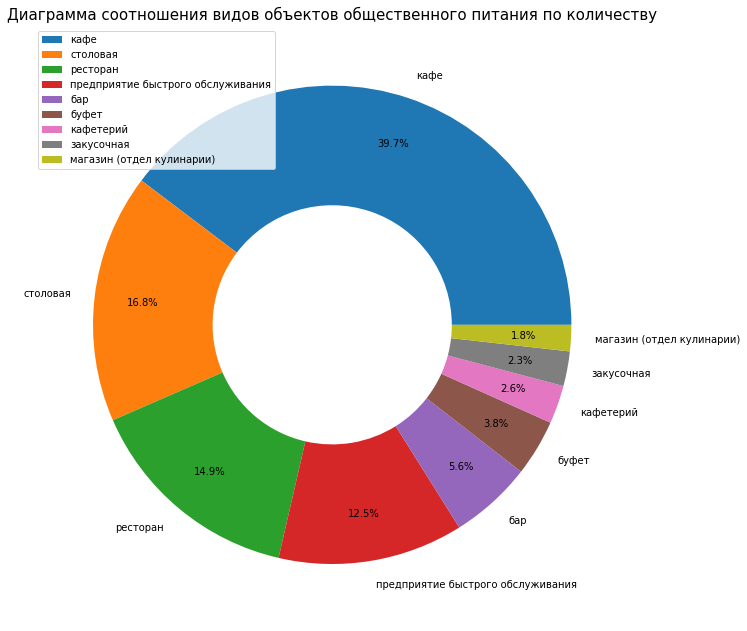

In [6]:
object_type = rest_data.groupby('object_type').agg({'id': 'count'})
object_type = object_type['id'].sort_values(ascending=False)
ax = object_type.plot(kind='pie',subplots=True,figsize=(11,11),autopct='%1.1f%%',wedgeprops=dict(width=0.5),pctdistance=0.8)
plt.legend(loc=2)
plt.title('Диаграмма соотношения видов объектов общественного питания по количеству',size=15)
plt.ylabel('');

На графике наглядно видим, что большая часть объектов в датасете - кафе (примерно одна треть от всех типов заведений)

### Исследуем соотношение сетевых и несетевых заведений по количеству

In [7]:
def chain_group(chain): 
    if chain == 'да':
        return 'сетевое заведение'
    else:
        return 'несетевое заведение'
rest_data['chain_group'] = rest_data['chain'].apply(chain_group)  

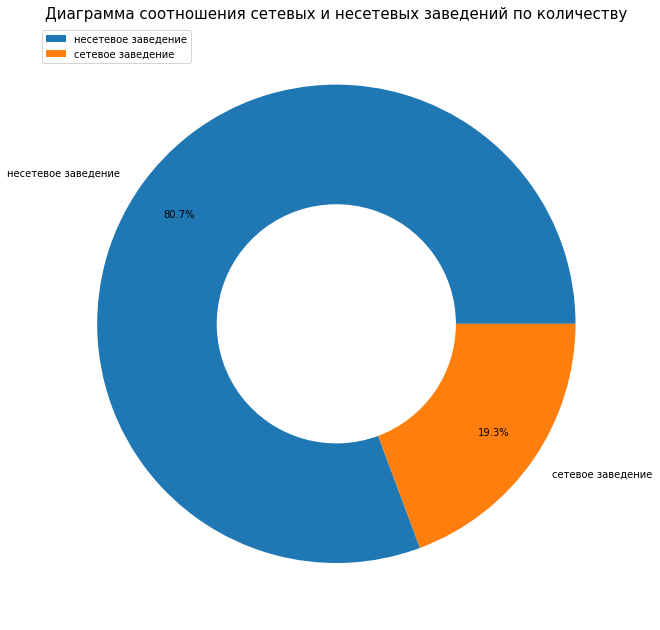

In [8]:
chain = rest_data.groupby('chain_group').agg({'id': 'count'})

chain = chain['id'].sort_values(ascending=False)
ax = chain.plot(kind='pie',subplots=True,figsize=(11,11),autopct='%1.1f%%',wedgeprops=dict(width=0.5),pctdistance=0.8)
plt.legend(loc=2)
plt.title('Диаграмма соотношения сетевых и несетевых заведений по количеству',size=15)
plt.ylabel('');

Подавляющее количество данных в датасете - несетевые заведения (80%)

### Для какого вида объекта общественного питания характерно сетевое распространение?

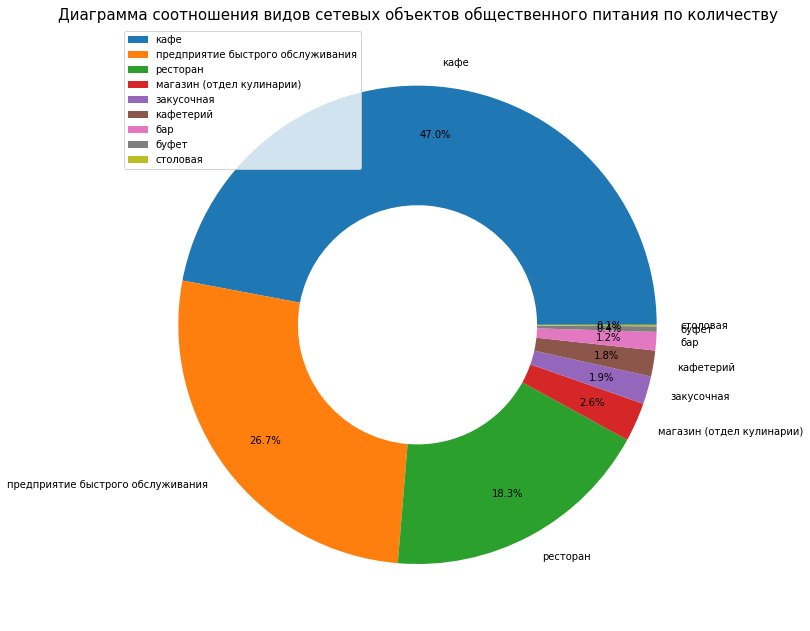

In [9]:
chain_object = rest_data.query('chain == "да"')
chain_object1 = chain_object.groupby('object_type').agg({'id': 'count'})
chain_object1 = chain_object1['id'].sort_values(ascending=False)
ax = chain_object1.plot(kind='pie',subplots=True,figsize=(11,11),autopct='%1.1f%%',wedgeprops=dict(width=0.5),pctdistance=0.8)
plt.legend(loc=2)
plt.title('Диаграмма соотношения видов сетевых объектов общественного питания по количеству',size=15)
plt.ylabel('');

На графике можно выделить тройку лидеров, для которых характерно сетевое распространение:
 1. Кафе (47% от всего количества сетевых заведений)
 2. Предприятия быстрого обслуживания (26.7% от всего количества сетевых заведений)
 3. Рестораны (18.3% от всего количества сетевых заведений)

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [10]:
chain_object

,id,object_name,chain,object_type,address,number,chain_group
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,сетевое заведение
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,сетевое заведение
13,22579,алло пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32,сетевое заведение
16,144107,суши wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7,сетевое заведение
18,58565,тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160,сетевое заведение
...,...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,сетевое заведение
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,сетевое заведение
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,сетевое заведение
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,сетевое заведение


Посмотрим, какое количество посадочных мест характерно для сетевых заведений

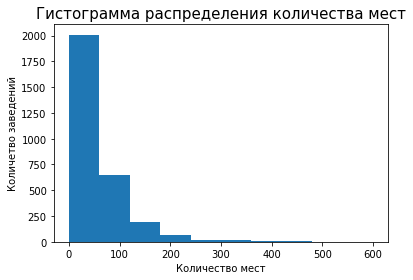

In [11]:
plt.hist(chain_object['number'], range=(0,600))  
plt.title('Гистограмма распределения количества мест',size=15)
plt.xlabel('Количество мест')
plt.ylabel('Количетво заведений');

По гистограмме можно сделать вывод, что большее количество заведений может принять до 50 гостей. Посмотрим ближе:

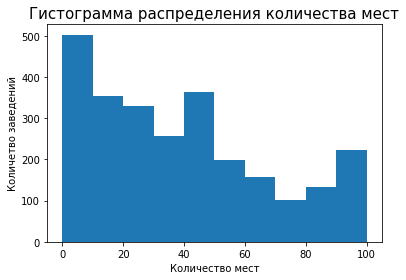

In [12]:
plt.hist(chain_object['number'], range=(0,100))  
plt.title('Гистограмма распределения количества мест',size=15)
plt.xlabel('Количество мест')
plt.ylabel('Количетво заведений');

10 - наиболее часто встречающееся количество посадочных мест

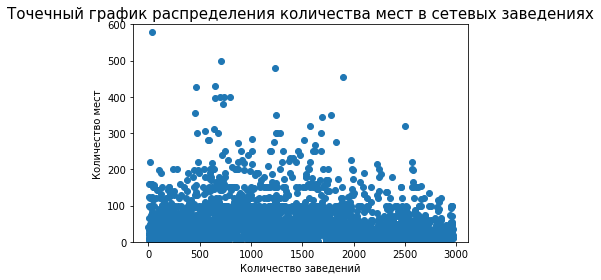

In [13]:
x_values = pd.Series(range(0,len(chain_object['number'])))
plt.scatter(x_values, chain_object['number'])
plt.ylim([0,600])
plt.title('Точечный график распределения количества мест в сетевых заведениях',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [14]:
chain_object['object_name'].unique() #видим, что названия сетей записаны очень по разному. 
#Лемматизиция займет очень много времени и усилий, поэтому сделаем расчет по тому, что есть

array(['пиццетория', 'брусника', 'алло пицца', 'суши wok', 'тануки',
       "домино'с пицца", 'готика', 'му-му', 'хлеб насущный', 'tajj mahal',
       'данкин донатс', 'вареничная №1', 'шоколадница', 'теремок',
       'хинкальная', 'шантимель', 'хинкальная city', 'кружка', 'суши вок',
       'примавера', 'виктория', 'пиццерия «академия»', 'чебуречная ссср',
       'макдоналдс', 'grand cru', 'чайхона №1', 'панчо пицца', 'kfc',
       'сабвей', 'ресторан «якитория»', 'советские времена',
       'кафе «андерсон»', 'кафе «subway»', 'ресторан «макдоналдс»',
       'суши сет', 'шоколад', 'тирольские пироги', 'гамбринус',
       'пицца фабрика', 'subway', 'кафе «якитория»', 'кафе «тануки»',
       'сити пицца', 'кофе хаус',
       'кулинарная лавка братьев караваевых братья караваевы', 'прайм',
       'пицца экспресс', 'шоколадница кофе хаус', 'николай', 'якитория',
       'магнолия', 'кофе с собой', 'джаганнат', 'волконский', 'moskalyan',
       'гино-но-таки', 'тратория semplice', 'ньокки',

In [15]:
chain_object.groupby('object_name')['id'].count().mean()

5.143847487001733

Среднее количество заведений - пять. Делаем вывод:
 Наиболее характерное сочетание для сетевых заведений это пять точек с 10 посадочными местами

### Для каждого вида объекта общественного питания опишем среднее количество посадочных мест

In [16]:
rest_data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

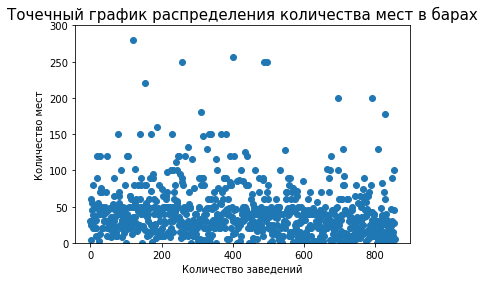

In [17]:
bar = rest_data.query('object_type=="бар"')
x_values = pd.Series(range(0,len(bar['number'])))
plt.scatter(x_values, bar['number'])
plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в барах',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [18]:
bar_mean = bar['number'].mean()
bar_mean

43.49415887850467

Среднее количество посадочных мест в заведениях типа "бар" - 43. Большинство заведений имеет до 50 посадочных мест. Есть одно выделяющееся заведение, в котором почти 300 мест

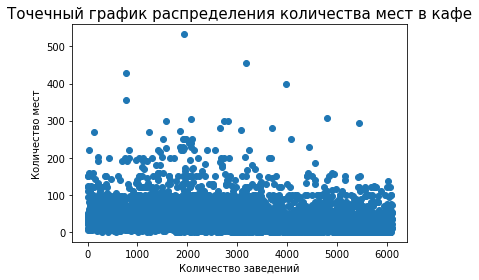

In [19]:
cafe = rest_data.query('object_type=="кафе"')

x_values = pd.Series(range(0,len(cafe['number'])))
plt.scatter(x_values, cafe['number'])
#plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в кафе',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [20]:
cafe_mean = cafe['number'].mean()
cafe_mean

39.71601901951139

Среднее количество посадочных мест в заведениях типа "кафе" - 40. Большинство заведений имеет до 100 посадочных мест. Есть одно выделяющееся заведение, в котором больше 500 мест

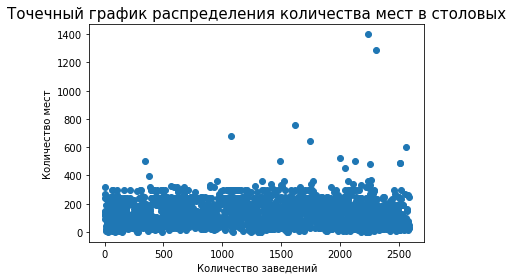

In [21]:
stol = rest_data.query('object_type=="столовая"')

x_values = pd.Series(range(0,len(stol['number'])))
plt.scatter(x_values, stol['number'])
#plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в столовых',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [22]:
stol_mean = stol['number'].mean()
stol_mean

130.24661770390415

Среднее количество посадочных мест в заведениях типа "столовая" - 130. Большинство заведений имеет до 300 посадочных мест. Есть одно выделяющееся заведение, в котором больше 1400 мест

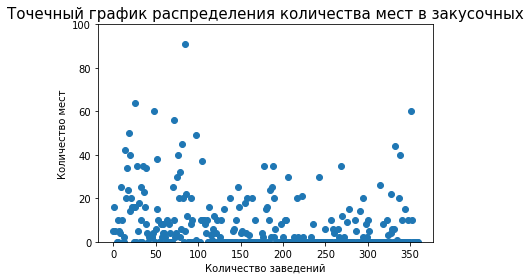

In [23]:
zakus = rest_data.query('object_type=="закусочная"')

x_values = pd.Series(range(0,len(zakus['number'])))
plt.scatter(x_values, zakus['number'])
plt.ylim([0,100])
plt.title('Точечный график распределения количества мест в закусочных',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [24]:
zakus_mean = zakus['number'].mean()
zakus_mean

7.608333333333333

Среднее количество посадочных мест в заведениях типа "закусочная" - 7. Большинство заведений имеет до 10 посадочных мест. Есть одно выделяющееся заведение, в котором больше 100 мест

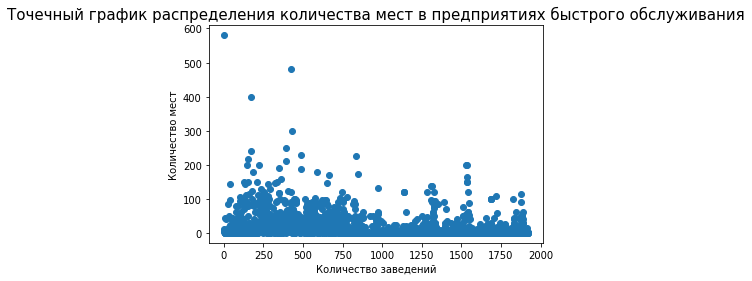

In [25]:
fastfood = rest_data.query('object_type=="предприятие быстрого обслуживания"')

x_values = pd.Series(range(0,len(fastfood['number'])))
plt.scatter(x_values, fastfood['number'])
#plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в предприятиях быстрого обслуживания',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [26]:
fastfood_mean = fastfood['number'].mean()
fastfood_mean

20.55226209048362

Среднее количество посадочных мест в заведениях типа "фастфуд" - 20. Большинство заведений имеет до 100 посадочных мест. Есть одно выделяющееся заведение, в котором больше 500 мест

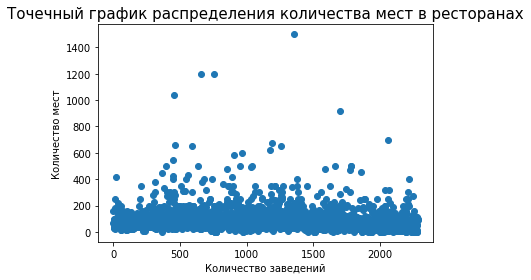

In [27]:
restoran = rest_data.query('object_type=="ресторан"')

x_values = pd.Series(range(0,len(restoran['number'])))
plt.scatter(x_values, restoran['number'])
#plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в ресторанах',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [28]:
restoran_mean = restoran['number'].mean()
restoran_mean

96.83413566739605

Среднее количество посадочных мест в заведениях типа "ресторан" - 97. Большинство заведений имеет до 200 посадочных мест. Есть одно выделяющееся заведение, в котором больше 1400 мест

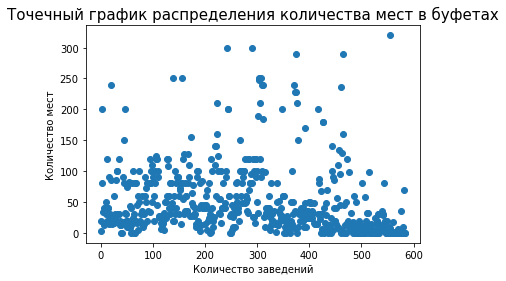

In [29]:
bufet = rest_data.query('object_type=="буфет"')

x_values = pd.Series(range(0,len(bufet['number'])))
plt.scatter(x_values, bufet['number'])
#plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в буфетах',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [30]:
bufet_mean = bufet['number'].mean()
bufet_mean

51.12991452991453

Среднее количество посадочных мест в заведениях типа "буфет" - 51. Большинство заведений имеет до 50 посадочных мест. Есть одно выделяющееся заведение, в котором больше 300 мест

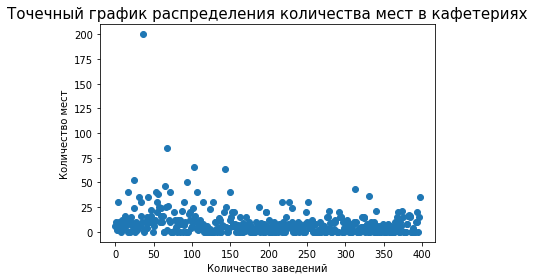

In [31]:
kafet = rest_data.query('object_type=="кафетерий"')

x_values = pd.Series(range(0,len(kafet['number'])))
plt.scatter(x_values, kafet['number'])
#plt.ylim([0,300])
plt.title('Точечный график распределения количества мест в кафетериях',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [32]:
kafet_mean = kafet['number'].mean()
kafet_mean

9.123115577889447

Среднее количество посадочных мест в заведениях типа "кафетерий" - 9. Большинство заведений имеет до 25 посадочных мест. Есть одно выделяющееся заведение, в котором больше 200 мест

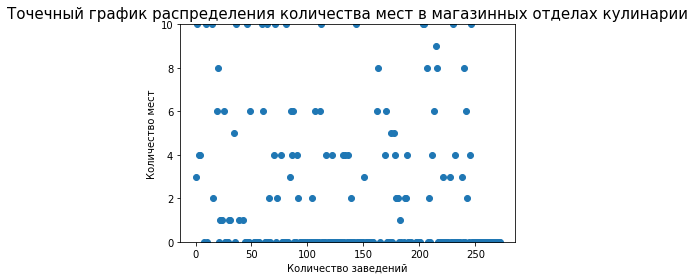

In [33]:

mag = rest_data.query('object_type=="магазин (отдел кулинарии)"')

x_values = pd.Series(range(0,len(mag['number'])))
plt.scatter(x_values, mag['number'])
plt.ylim([0,10])
plt.title('Точечный график распределения количества мест в магазинных отделах кулинарии',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

In [34]:
mag_mean = mag['number'].mean()
mag_mean

5.589743589743589

Среднее количество посадочных мест в заведениях типа "магазин (отдел кулинарии)" - 5. Большинство заведений имеет до 2 посадочных мест. 

В среднем самое большое количество посадочных мест у заведений типа "столовая" (130)

### Выделим в отдельный столбец информацию об улице из столбца address 

In [35]:
rest_data

,id,object_name,chain,object_type,address,number,chain_group
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,несетевое заведение
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,несетевое заведение
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,несетевое заведение
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,сетевое заведение
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,несетевое заведение
...,...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,сетевое заведение
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,сетевое заведение
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,сетевое заведение
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,сетевое заведение


In [36]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

rest_data["street"] = rest_data["address"].str.extract(str_pat)
rest_data

,id,object_name,chain,object_type,address,number,chain_group,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,несетевое заведение,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,несетевое заведение,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,несетевое заведение,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,сетевое заведение,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,несетевое заведение,Абрамцевская улица
...,...,...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,сетевое заведение,3-й Крутицкий переулок
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,сетевое заведение,улица Земляной Вал
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,сетевое заведение,улица Земляной Вал
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,сетевое заведение,Киевское шоссе


### Построим график топ-10 улиц по количеству объектов общественного питания. Посмотрим, в каких районах находятся эти улицы

Определим топ-10 улиц по количеству объектов

In [37]:
count_street = rest_data.pivot_table(index='street', values='id',aggfunc='count')
top_street = count_street['id'].sort_values(ascending=False).head(10)

top_street

street
проспект Мира             204
Профсоюзная улица         182
Ленинградский проспект    171
Пресненская набережная    167
Варшавское шоссе          164
Ленинский проспект        147
проспект Вернадского      132
Кутузовский проспект      114
Каширское шоссе           112
Кировоградская улица      110
Name: id, dtype: int64

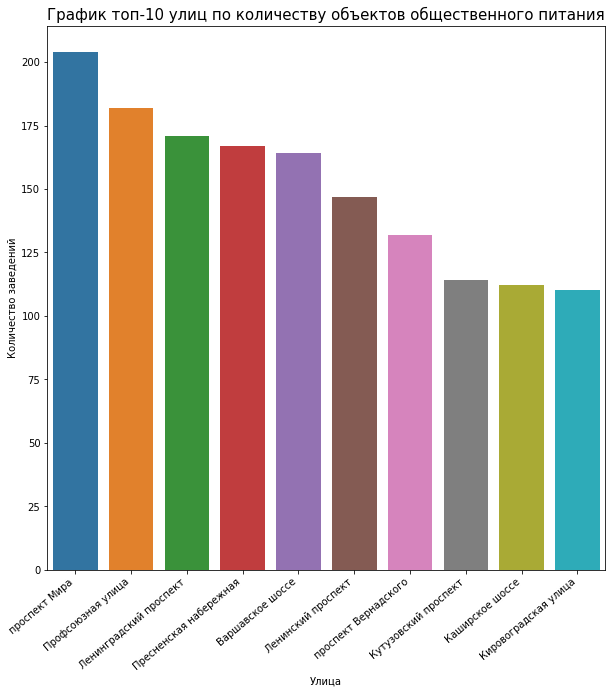

In [38]:
plt.figure(figsize=(10,10))
ax2 = sns.barplot(top_street.index, top_street)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
plt.title('График топ-10 улиц по количеству объектов общественного питания',size=15)
plt.xlabel('Улица')
plt.ylabel('Количество заведений');

Из графика видим абсолютного победителя - проспект Мира. На этой улице более 200 заведений. Посмотрим, в каких районах находятся эти улицы. Добавим из внешнего источника районы

In [39]:
from io import BytesIO
import requests
spreadsheet_id = '1SEMSnbxWdTh1dgO0g839K_FSm2aSg8L5AiT9zfKK17o'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
districts = pd.read_csv(BytesIO(r.content))
districts = districts.rename(columns={'streetname': 'street'})
districts

,street,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [40]:
top_district = pd.merge(top_street, districts, on = 'street')
top_district

,street,id,areaid,okrug,area
0,проспект Мира,204,70,СВАО,Алексеевский район
1,проспект Мира,204,86,СВАО,Ярославский Район
2,проспект Мира,204,78,СВАО,Район Марьина роща
3,проспект Мира,204,79,СВАО,Останкинский район
4,проспект Мира,204,81,СВАО,Район Ростокино
5,проспект Мира,204,82,СВАО,Район Свиблово
6,проспект Мира,204,16,ЦАО,Мещанский район
7,Профсоюзная улица,182,123,ЮЗАО,Академический район
8,Профсоюзная улица,182,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,182,134,ЮЗАО,Район Ясенево


In [41]:
top_district.groupby('okrug')['street'].count()


okrug
ЗАО      7
САО      4
СВАО     6
ЦАО      3
ЮАО     14
ЮЗАО    14
Name: street, dtype: int64

Большинство улиц, на которых много заведений, находятся в ЮЗАО и ЮАО, то есть на юге Москвы.

### Найдем число улиц с одним объектом общественного питания. Посмотрим, в каких районах находятся эти улицы

In [42]:
one = count_street.query('id == 1')
one_district = pd.merge(one, districts, on = 'street')
one_district

,street,id,areaid,okrug,area
0,1-й Балтийский переулок,1,54,САО,Район Аэропорт
1,1-й Басманный переулок,1,13,ЦАО,Басманный район
2,1-й Басманный переулок,1,15,ЦАО,Красносельский район
3,1-й Ботанический проезд,1,82,СВАО,Район Свиблово
4,1-й Вешняковский проезд,1,120,ЮВАО,Рязанский район
...,...,...,...,...,...
559,улица Шеногина,1,92,СЗАО,Район Хорошево-Мневники
560,улица Шумилова,1,113,ЮВАО,Район Кузьминки
561,улица Шумкина,1,26,ВАО,Район Сокольники
562,улица Щорса,1,46,ЗАО,Район Солнцево


In [43]:
one_district = one_district.groupby('okrug')['street'].count()
one_district.sort_values(ascending=False)

okrug
ЦАО           186
ВАО            67
СВАО           66
ЮВАО           55
САО            55
ЗАО            45
ЮАО            29
ЮЗАО           28
СЗАО           27
Зеленоград      6
Name: street, dtype: int64

Подавляющее большинство улиц, на которых только одна точка общепита, находятся в ЦАО. Это объяснимо тем, что в этом районе очень дорогая аренда помещений

### Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

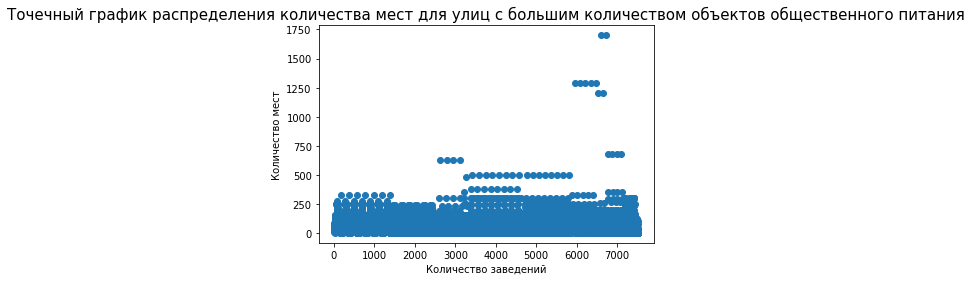

In [44]:
top_district
data = pd.merge(top_district, rest_data, on = 'street')
x_values = pd.Series(range(0,len(data['number'])))
plt.scatter(x_values, data['number'])

plt.title('Точечный график распределения количества мест для улиц с большим количеством объектов общественного питания',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

Обрежем выбросы на графике и посмотрим ближе

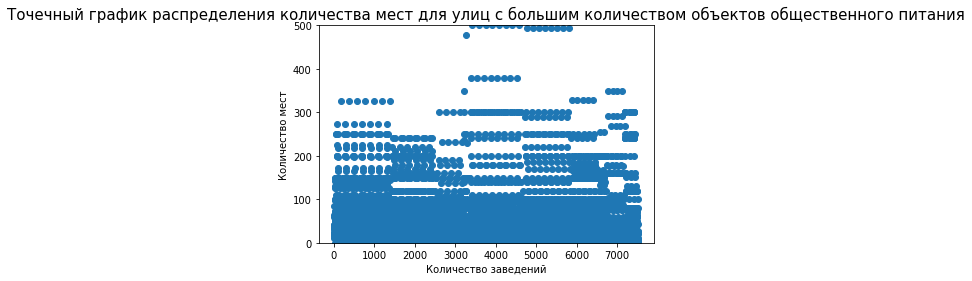

In [45]:
x_values = pd.Series(range(0,len(data['number'])))
plt.scatter(x_values, data['number'])
plt.ylim([0,500])
plt.title('Точечный график распределения количества мест для улиц с большим количеством объектов общественного питания',size=15)
plt.xlabel('Количество заведений')
plt.ylabel('Количество мест');

Видим, что основная плотность на уровне 100 мест и ниже этого показателя.

### Общий вывод и рекомендации

**Общий вывод** 
 
 - Большая часть объектов общепита имеют статус "кафе" (39.7%), на втором и третьем месте "столовая" (16.8%) и "ресторан" (14.9%)
 - Только 20% заведений на рынке являются сетевыми
 - Чаще всего сетевыми являются кафе и фастфуд
 - Для сетевых заведений характерно иметь много заведений (около 5) с малым количеством мест (около 10)
 - Самое большое количество средних мест обычно у столовых (около 130)
 - Улица, на которой больше всего заведений - проспект Мира. Она проходит через 7 районов
 - Больше всего улиц с большим количеством заведений находится на юге Москвы - ЮЗАО и ЮАО
 - Подавляющее большинство улиц, на которых только одна точка общепита, находятся в ЦАО. Это объяснимо тем, что в этом районе очень дорогая аренда помещений
 - Для заведений, которые находятся среди плотной среды конкурентов, характерно иметь до 100 посадочных мест
 
**Рекомендации**
 
 - Вид заведения

Сама концепция - роботы вместо персонала - привлечет в первую очередь молодую аудиторию, активно интересующуюся технологиями, следящую за трендами. Поскольку в проект нужно влить много денег, ценник так же скорее всего будет высоким. ЦА проекта - молодые успешные люди 25-35 лет, работники крупных компаний. Поэтому вид рекомендуемый вид заведения - кафе или ресторан.

- Количество посадочных мест

Данные показали, что среднее количество посадочных мест в ресторанах - 97, а в кафе - 40. Если учесть, что расходы предстоят высокие, рекомендую остановиться на 40-45 посадочных местах

- Район расположения

В районах, где высокая плотность заведений общепита, сложно привлечь и удержать внимание посетителей. Поэтому лучшим вариантом будут улицы и районы, где заведений не очень много. Опираясь на ЦА и данные, показывающие, что самая большая плотность улиц с одним заведением располагается в ЦАО, рекомендую этот район.

- Возможность развития сети

Сетевые заведения обычно небольшие, на маленькое количество посадочных мест. Для таких заведений вкладывать много денег в робота кажется нецелесообразным

## Презентация

https://drive.google.com/file/d/103TRjSXOUD0PErOjra3nZC2C4-y1EfhX/view?usp=sharing